# Classification Models for Power Outage Severity Prediction

This notebook builds and evaluates classification models to predict power outage severity based on wildfire characteristics and other features.

## Objectives
1. Predict **high-severity outages** (>50,000 customers OR >1,000 MW demand loss)
2. Predict **long-duration outages** (>8 hours)
3. Predict **wildfire-related outages**

## Models Implemented
- Decision Tree Classifier
- Random Forest Classifier
- Support Vector Machine (SVM)
- Gradient Boosting Classifier

## Research Question Addressed
> Can we predict power outage severity based on wildfire characteristics and weather conditions?

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, roc_auc_score,
    ConfusionMatrixDisplay, RocCurveDisplay
)
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
pd.set_option('display.max_columns', 50)

# Path configuration
FEATURES_PATH = '../data/features/'
OUTPUTS_PATH = '../outputs/'

In [3]:
# Load the feature-engineered dataset
df = pd.read_csv(FEATURES_PATH + 'california_outages_with_fire_features.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nTarget variables available:")
print(f"  - is_high_severity: {df['is_high_severity'].value_counts().to_dict()}")
print(f"  - is_long_duration: {df['is_long_duration'].value_counts().to_dict()}")
print(f"  - is_wildfire_related: {df['is_wildfire_related'].value_counts().to_dict()}")

df.head()

Dataset shape: (210, 35)

Target variables available:
  - is_high_severity: {0: 134, 1: 76}
  - is_long_duration: {0: 131, 1: 79}
  - is_wildfire_related: {0: 194, 1: 16}


,outage_date,outage_year,outage_month,outage_dayofweek,outage_quarter,season,is_wildfire_season,is_weekend,CAUSE.CATEGORY,CAUSE.CATEGORY.DETAIL,OUTAGE.DURATION,DEMAND.LOSS.MW,CUSTOMERS.AFFECTED,duration_category,impact_category,is_wildfire_related,daily_fire_count,daily_acres_burned,avg_fire_size,max_fire_size,large_fire_count,large_fire_acres,satellite_detections,total_frp,avg_frp,max_frp,avg_confidence,fires_7day,fires_30day,acres_7day,acres_30day,is_high_severity,is_long_duration,has_active_fire,is_high_fire_activity
0,2007-09-04,2007,9,1,3,Fall,1,0,severe weather,heatwave,420.0,NaN,NaN,Medium,Unknown,0,48.0,24.55,0.511458,5.0,0.0,0.0,165.0,34776.4,210.766061,2500.9,89.836364,480.0,1473.0,119713.43,134779.78,0,0,1,1
1,2008-05-08,2008,5,3,2,Spring,0,0,system operability disruption,NaN,155.0,483.0,NaN,Medium,Unknown,0,16.0,76.70,4.793750,52.0,0.0,0.0,17.0,520.6,30.623529,175.7,70.529412,133.0,693.0,2752.66,5495.77,0,0,1,0
2,2006-05-19,2006,5,4,2,Spring,0,0,severe weather,thunderstorm,437.0,133.0,NaN,Medium,Unknown,0,15.0,14.10,0.940000,10.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,194.0,399.0,2759.14,3000.94,0,0,1,0
3,2015-10-13,2015,10,1,4,Fall,1,0,public appeal,NaN,247.0,41788.0,NaN,Medium,Unknown,0,20.0,255.25,12.762500,250.0,0.0,0.0,13.0,1615.2,124.246154,418.1,79.615385,126.0,572.0,1100.93,3807.79,1,0,1,1
4,2014-02-06,2014,2,3,1,Winter,0,0,fuel supply emergency,Natural Gas,540.0,4000.0,NaN,Long,Unknown,0,3.0,1.20,0.400000,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,61.0,445.0,43.52,4157.61,1,1,1,0


---
## Data Preparation

We prepare features for classification by:
1. Selecting relevant predictor features
2. Handling missing values
3. Encoding categorical variables
4. Scaling numeric features

In [4]:
# Define feature groups
# Temporal features
temporal_features = ['outage_month', 'outage_dayofweek', 'outage_quarter', 
                     'is_wildfire_season', 'is_weekend']

# Fire activity features
fire_features = ['daily_fire_count', 'daily_acres_burned', 'avg_fire_size', 'max_fire_size',
                 'large_fire_count', 'large_fire_acres', 'satellite_detections',
                 'total_frp', 'avg_frp', 'max_frp', 'avg_confidence',
                 'fires_7day', 'fires_30day', 'acres_7day', 'acres_30day',
                 'has_active_fire', 'is_high_fire_activity']

# Categorical features to encode
categorical_features = ['season', 'CAUSE.CATEGORY']

# Filter to existing columns
temporal_features = [col for col in temporal_features if col in df.columns]
fire_features = [col for col in fire_features if col in df.columns]
categorical_features = [col for col in categorical_features if col in df.columns]

all_features = temporal_features + fire_features + categorical_features
print(f"Total features: {len(all_features)}")
print(f"  Temporal: {len(temporal_features)}")
print(f"  Fire activity: {len(fire_features)}")
print(f"  Categorical: {len(categorical_features)}")

Total features: 24
  Temporal: 5
  Fire activity: 17
  Categorical: 2


In [5]:
def prepare_classification_data(df, target_col, feature_cols, categorical_cols):
    """
    Prepare features and target for classification.
    Handles missing values and encodes categorical features.
    """
    # Create copy
    data = df.copy()
    
    # Remove rows where target is missing
    data = data[data[target_col].notna()]
    
    # Separate features
    X = data[feature_cols].copy()
    y = data[target_col].copy()
    
    # Handle missing values in numeric columns
    numeric_cols = X.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 0:
        imputer = SimpleImputer(strategy='median')
        X[numeric_cols] = imputer.fit_transform(X[numeric_cols])
    
    # One-hot encode categorical columns
    X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)
    
    return X, y

# Prepare data for high severity prediction
X, y = prepare_classification_data(df, 'is_high_severity', all_features, categorical_features)

print(f"Feature matrix shape: {X.shape}")
print(f"Target distribution:\n{y.value_counts()}")
print(f"\nClass balance: {y.mean()*100:.1f}% positive (high severity)")

Feature matrix shape: (210, 31)
Target distribution:
is_high_severity
0    134
1     76
Name: count, dtype: int64

Class balance: 36.2% positive (high severity)


In [6]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"\nTraining class distribution:\n{y_train.value_counts()}")
print(f"\nTest class distribution:\n{y_test.value_counts()}")

# Scale features for SVM
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Training set: 168 samples
Test set: 42 samples

Training class distribution:
is_high_severity
0    107
1     61
Name: count, dtype: int64

Test class distribution:
is_high_severity
0    27
1    15
Name: count, dtype: int64


---
## Model Training and Evaluation

We train multiple classifiers and compare their performance.

In [7]:
def evaluate_classifier(model, X_train, X_test, y_train, y_test, model_name):
    """
    Train and evaluate a classifier, returning metrics and predictions.
    """
    # Train
    model.fit(X_train, y_train)
    
    # Predict
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    
    # Calculate metrics
    metrics = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, zero_division=0),
        'Recall': recall_score(y_test, y_pred, zero_division=0),
        'F1 Score': f1_score(y_test, y_pred, zero_division=0),
        'ROC-AUC': roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else np.nan
    }
    
    # Cross-validation score
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1')
    metrics['CV F1 (mean)'] = cv_scores.mean()
    metrics['CV F1 (std)'] = cv_scores.std()
    
    return metrics, y_pred, y_pred_proba, model

In [8]:
# 1. Decision Tree Classifier
print("=" * 80)
print("DECISION TREE CLASSIFIER")
print("=" * 80)

dt_model = DecisionTreeClassifier(
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    class_weight='balanced'
)

dt_metrics, dt_pred, dt_proba, dt_trained = evaluate_classifier(
    dt_model, X_train, X_test, y_train, y_test, 'Decision Tree'
)

print(f"\nTest Set Performance:")
for metric, value in dt_metrics.items():
    if metric != 'Model' and not pd.isna(value):
        print(f"  {metric}: {value:.4f}")

print(f"\nClassification Report:")
print(classification_report(y_test, dt_pred, target_names=['Normal', 'High Severity']))

DECISION TREE CLASSIFIER

Test Set Performance:
  Accuracy: 0.7857
  Precision: 0.7143
  Recall: 0.6667
  F1 Score: 0.6897
  ROC-AUC: 0.7346
  CV F1 (mean): 0.6661
  CV F1 (std): 0.0947

Classification Report:
               precision    recall  f1-score   support

       Normal       0.82      0.85      0.84        27
High Severity       0.71      0.67      0.69        15

     accuracy                           0.79        42
    macro avg       0.77      0.76      0.76        42
 weighted avg       0.78      0.79      0.78        42



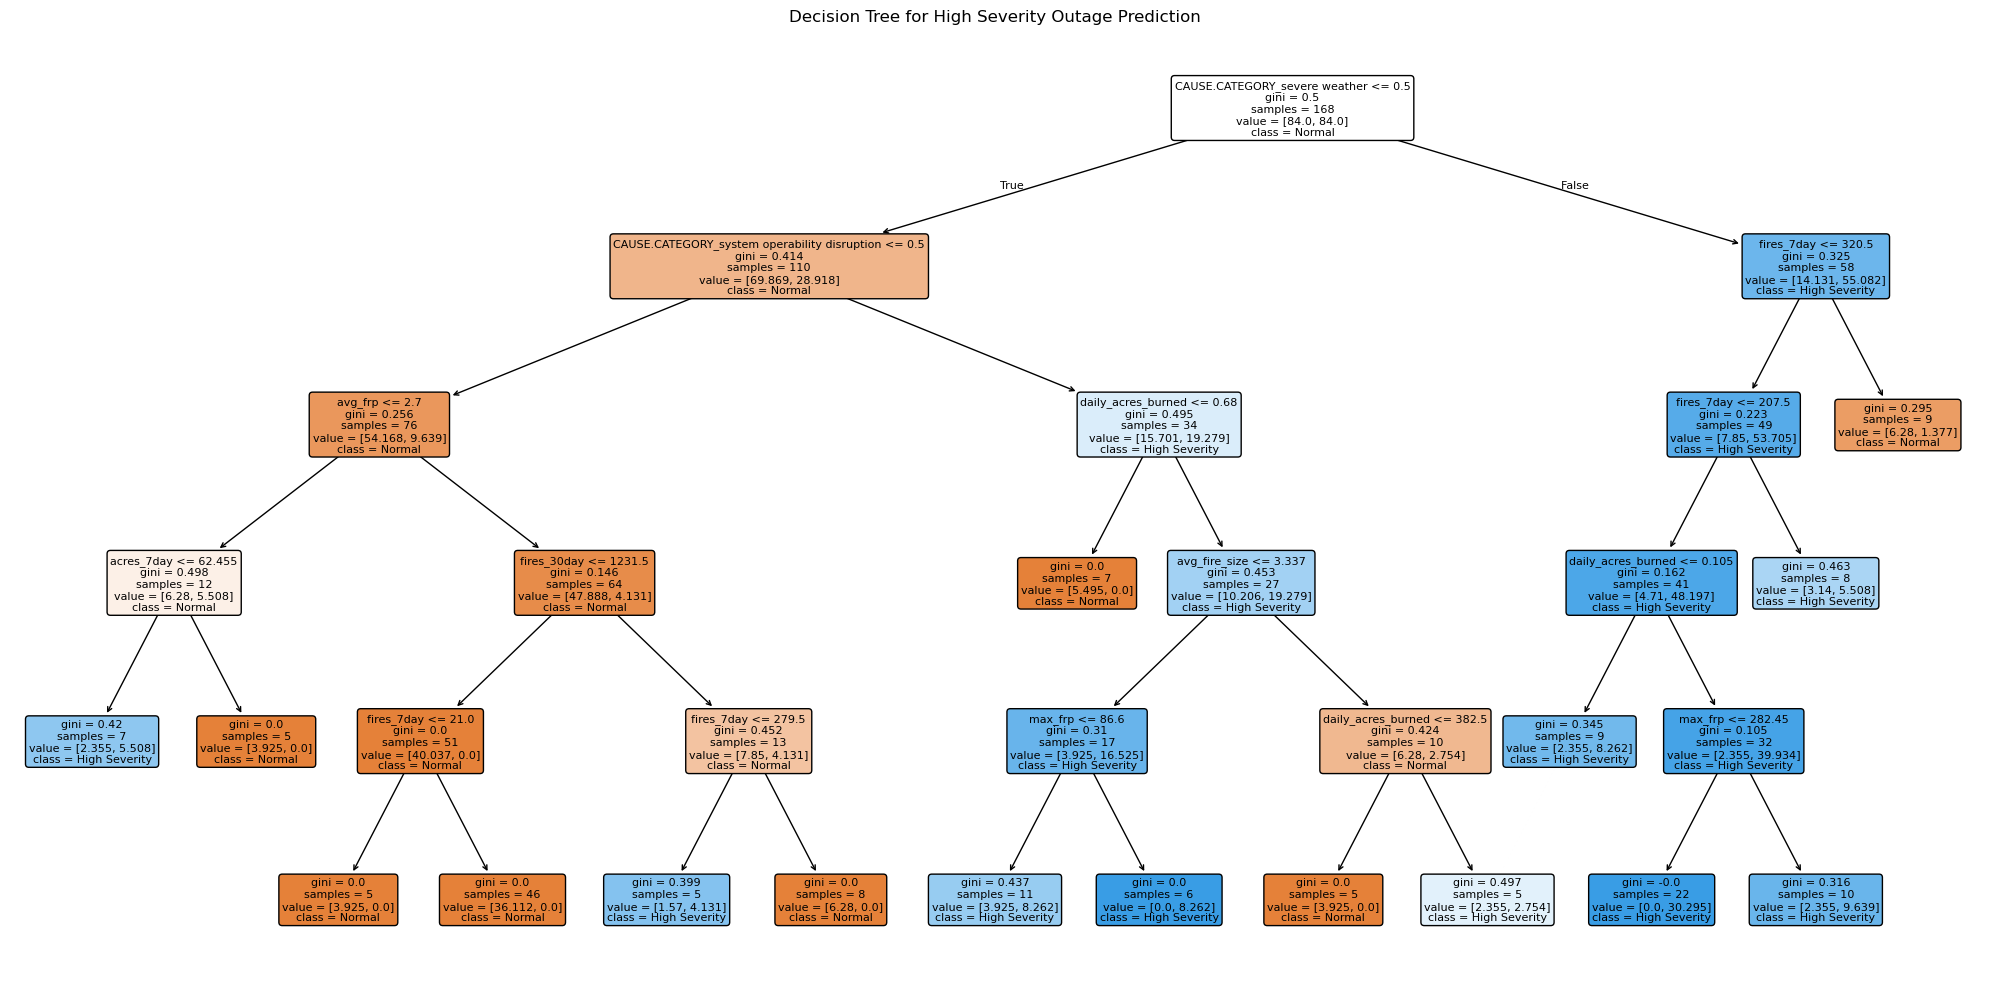

In [9]:
# Visualize Decision Tree
plt.figure(figsize=(20, 10))
plot_tree(
    dt_trained,
    feature_names=X.columns.tolist(),
    class_names=['Normal', 'High Severity'],
    filled=True,
    rounded=True,
    fontsize=8
)
plt.title('Decision Tree for High Severity Outage Prediction')
plt.tight_layout()
plt.savefig(OUTPUTS_PATH + 'figures/decision_tree_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

In [10]:
# 2. Random Forest Classifier
print("=" * 80)
print("RANDOM FOREST CLASSIFIER")
print("=" * 80)

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)

rf_metrics, rf_pred, rf_proba, rf_trained = evaluate_classifier(
    rf_model, X_train, X_test, y_train, y_test, 'Random Forest'
)

print(f"\nTest Set Performance:")
for metric, value in rf_metrics.items():
    if metric != 'Model' and not pd.isna(value):
        print(f"  {metric}: {value:.4f}")

print(f"\nClassification Report:")
print(classification_report(y_test, rf_pred, target_names=['Normal', 'High Severity']))

RANDOM FOREST CLASSIFIER

Test Set Performance:
  Accuracy: 0.7381
  Precision: 0.7000
  Recall: 0.4667
  F1 Score: 0.5600
  ROC-AUC: 0.7531
  CV F1 (mean): 0.6182
  CV F1 (std): 0.1381

Classification Report:
               precision    recall  f1-score   support

       Normal       0.75      0.89      0.81        27
High Severity       0.70      0.47      0.56        15

     accuracy                           0.74        42
    macro avg       0.72      0.68      0.69        42
 weighted avg       0.73      0.74      0.72        42



Top 15 Most Important Features:
                      feature  importance
CAUSE.CATEGORY_severe weather    0.123803
                   fires_7day    0.066971
                  fires_30day    0.059182
           daily_acres_burned    0.057409
                avg_fire_size    0.055756
                   acres_7day    0.053523
     CAUSE.CATEGORY_islanding    0.051747
         satellite_detections    0.048449
                max_fire_size    0.047708
                      max_frp    0.047202
                    total_frp    0.046999
                  acres_30day    0.046275
               avg_confidence    0.041610
             daily_fire_count    0.038218
                      avg_frp    0.035649


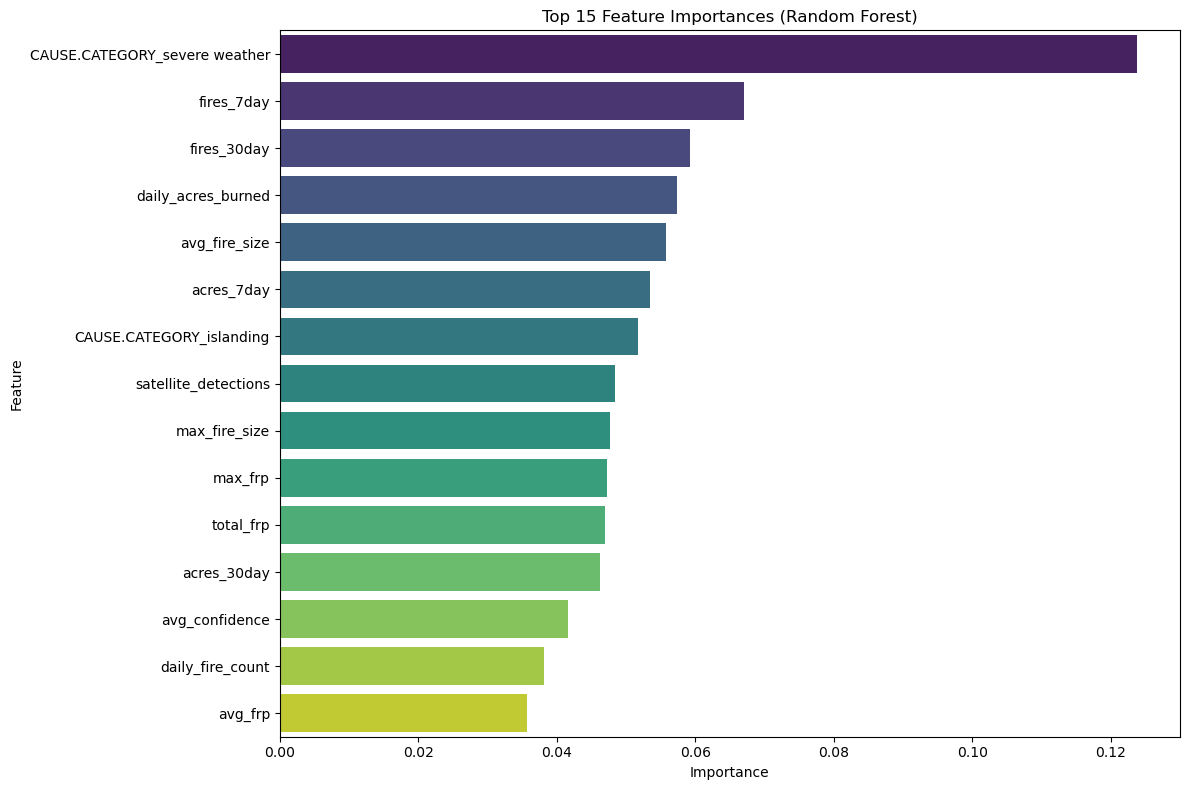

In [11]:
# Feature Importance from Random Forest
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_trained.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 15 Most Important Features:")
print(feature_importance.head(15).to_string(index=False))

# Plot feature importance
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(15)
sns.barplot(x='importance', y='feature', data=top_features, palette='viridis')
plt.title('Top 15 Feature Importances (Random Forest)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig(OUTPUTS_PATH + 'figures/feature_importance_rf.png', dpi=150, bbox_inches='tight')
plt.show()

In [12]:
# 3. Support Vector Machine (SVM)
print("=" * 80)
print("SUPPORT VECTOR MACHINE (SVM)")
print("=" * 80)

svm_model = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    class_weight='balanced',
    probability=True,
    random_state=42
)

svm_metrics, svm_pred, svm_proba, svm_trained = evaluate_classifier(
    svm_model, X_train_scaled, X_test_scaled, y_train, y_test, 'SVM (RBF)'
)

print(f"\nTest Set Performance:")
for metric, value in svm_metrics.items():
    if metric != 'Model' and not pd.isna(value):
        print(f"  {metric}: {value:.4f}")

print(f"\nClassification Report:")
print(classification_report(y_test, svm_pred, target_names=['Normal', 'High Severity']))

SUPPORT VECTOR MACHINE (SVM)

Test Set Performance:
  Accuracy: 0.8095
  Precision: 0.7333
  Recall: 0.7333
  F1 Score: 0.7333
  ROC-AUC: 0.8667
  CV F1 (mean): 0.6462
  CV F1 (std): 0.0604

Classification Report:
               precision    recall  f1-score   support

       Normal       0.85      0.85      0.85        27
High Severity       0.73      0.73      0.73        15

     accuracy                           0.81        42
    macro avg       0.79      0.79      0.79        42
 weighted avg       0.81      0.81      0.81        42



In [13]:
# 4. Gradient Boosting Classifier
print("=" * 80)
print("GRADIENT BOOSTING CLASSIFIER")
print("=" * 80)

gb_model = GradientBoostingClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)

gb_metrics, gb_pred, gb_proba, gb_trained = evaluate_classifier(
    gb_model, X_train, X_test, y_train, y_test, 'Gradient Boosting'
)

print(f"\nTest Set Performance:")
for metric, value in gb_metrics.items():
    if metric != 'Model' and not pd.isna(value):
        print(f"  {metric}: {value:.4f}")

print(f"\nClassification Report:")
print(classification_report(y_test, gb_pred, target_names=['Normal', 'High Severity']))

GRADIENT BOOSTING CLASSIFIER

Test Set Performance:
  Accuracy: 0.7143
  Precision: 0.7143
  Recall: 0.3333
  F1 Score: 0.4545
  ROC-AUC: 0.7062
  CV F1 (mean): 0.5843
  CV F1 (std): 0.1403

Classification Report:
               precision    recall  f1-score   support

       Normal       0.71      0.93      0.81        27
High Severity       0.71      0.33      0.45        15

     accuracy                           0.71        42
    macro avg       0.71      0.63      0.63        42
 weighted avg       0.71      0.71      0.68        42



---
## Model Comparison

In [14]:
# Compile all metrics
all_metrics = pd.DataFrame([dt_metrics, rf_metrics, svm_metrics, gb_metrics])

print("=" * 80)
print("MODEL COMPARISON - HIGH SEVERITY PREDICTION")
print("=" * 80)
print(all_metrics.round(4).to_string(index=False))

# Highlight best model
best_model_idx = all_metrics['F1 Score'].idxmax()
best_model = all_metrics.loc[best_model_idx, 'Model']
print(f"\nBest Model (by F1 Score): {best_model}")

MODEL COMPARISON - HIGH SEVERITY PREDICTION
            Model  Accuracy  Precision  Recall  F1 Score  ROC-AUC  CV F1 (mean)  CV F1 (std)
    Decision Tree    0.7857     0.7143  0.6667    0.6897   0.7346        0.6661       0.0947
    Random Forest    0.7381     0.7000  0.4667    0.5600   0.7531        0.6182       0.1381
        SVM (RBF)    0.8095     0.7333  0.7333    0.7333   0.8667        0.6462       0.0604
Gradient Boosting    0.7143     0.7143  0.3333    0.4545   0.7062        0.5843       0.1403

Best Model (by F1 Score): SVM (RBF)


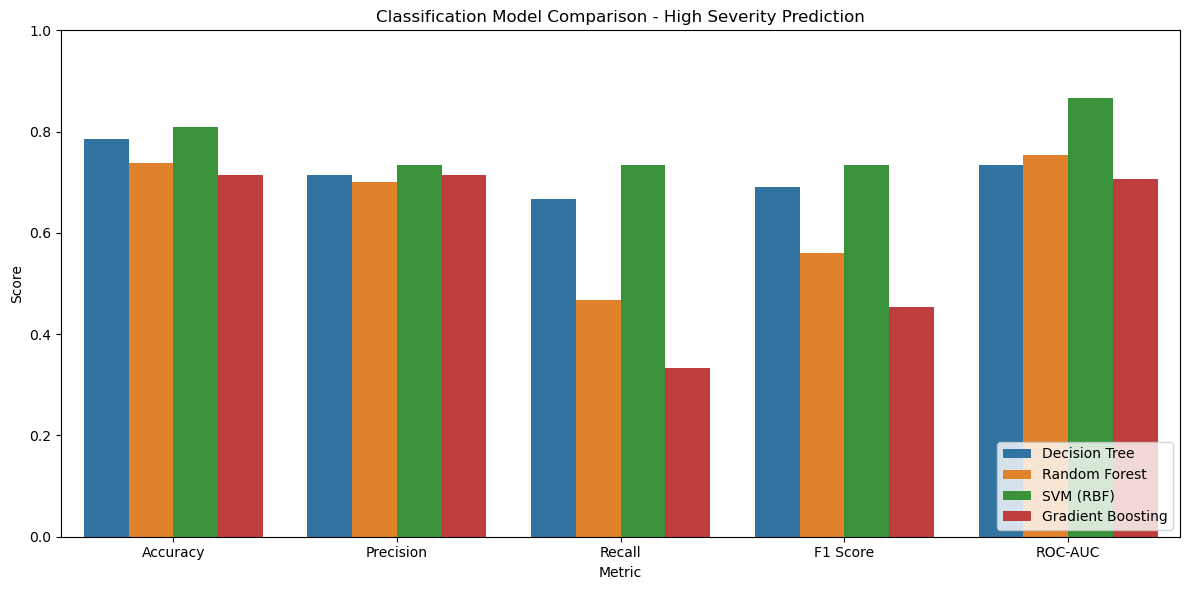

In [15]:
# Visualize model comparison
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC-AUC']
plot_data = all_metrics.melt(id_vars=['Model'], value_vars=metrics_to_plot, 
                              var_name='Metric', value_name='Score')

plt.figure(figsize=(12, 6))
sns.barplot(x='Metric', y='Score', hue='Model', data=plot_data)
plt.title('Classification Model Comparison - High Severity Prediction')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig(OUTPUTS_PATH + 'figures/classification_model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

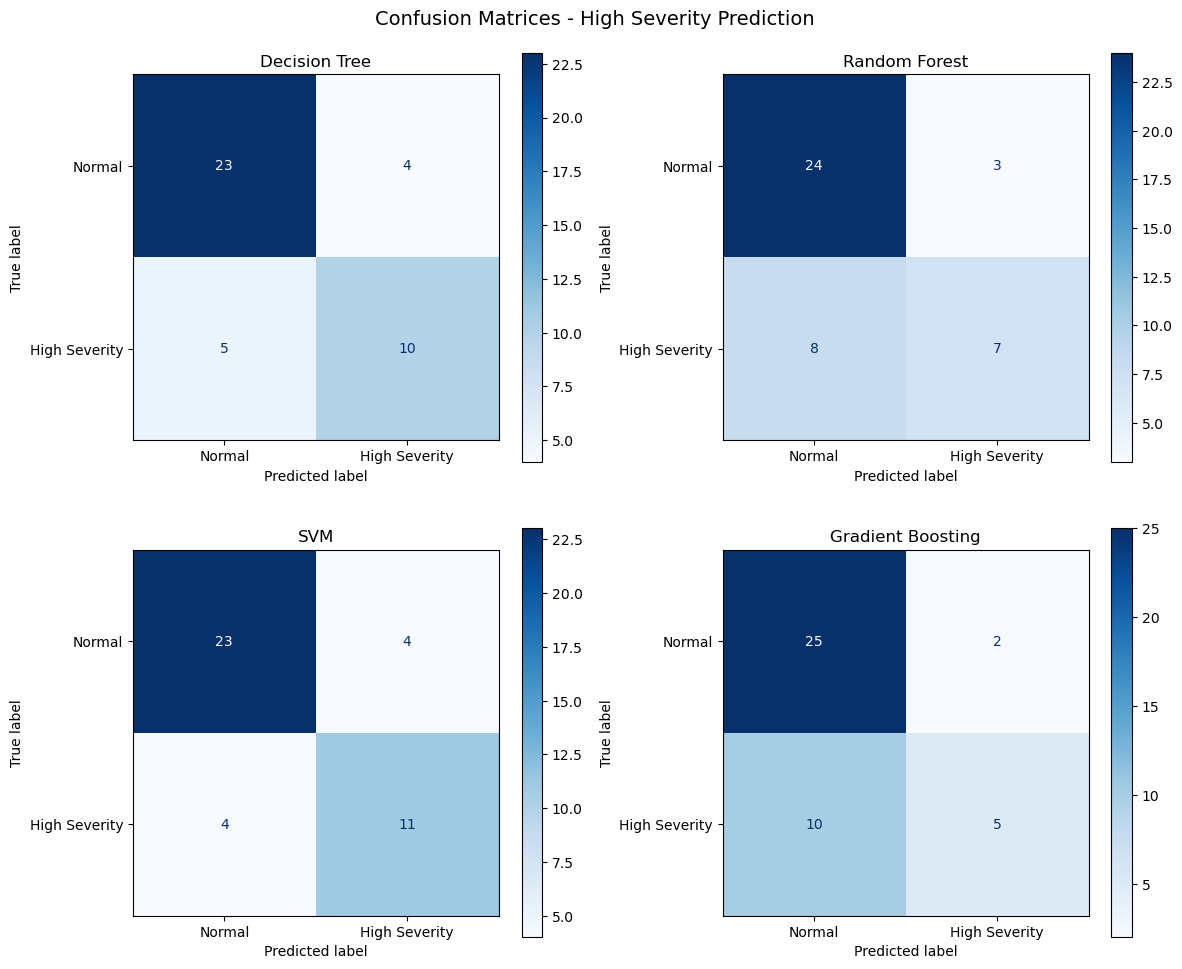

In [16]:
# Plot confusion matrices for all models
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

models_preds = [
    ('Decision Tree', dt_pred),
    ('Random Forest', rf_pred),
    ('SVM', svm_pred),
    ('Gradient Boosting', gb_pred)
]

for ax, (name, pred) in zip(axes.flatten(), models_preds):
    cm = confusion_matrix(y_test, pred)
    ConfusionMatrixDisplay(cm, display_labels=['Normal', 'High Severity']).plot(ax=ax, cmap='Blues')
    ax.set_title(f'{name}')

plt.suptitle('Confusion Matrices - High Severity Prediction', fontsize=14)
plt.tight_layout()
plt.savefig(OUTPUTS_PATH + 'figures/confusion_matrices.png', dpi=150, bbox_inches='tight')
plt.show()

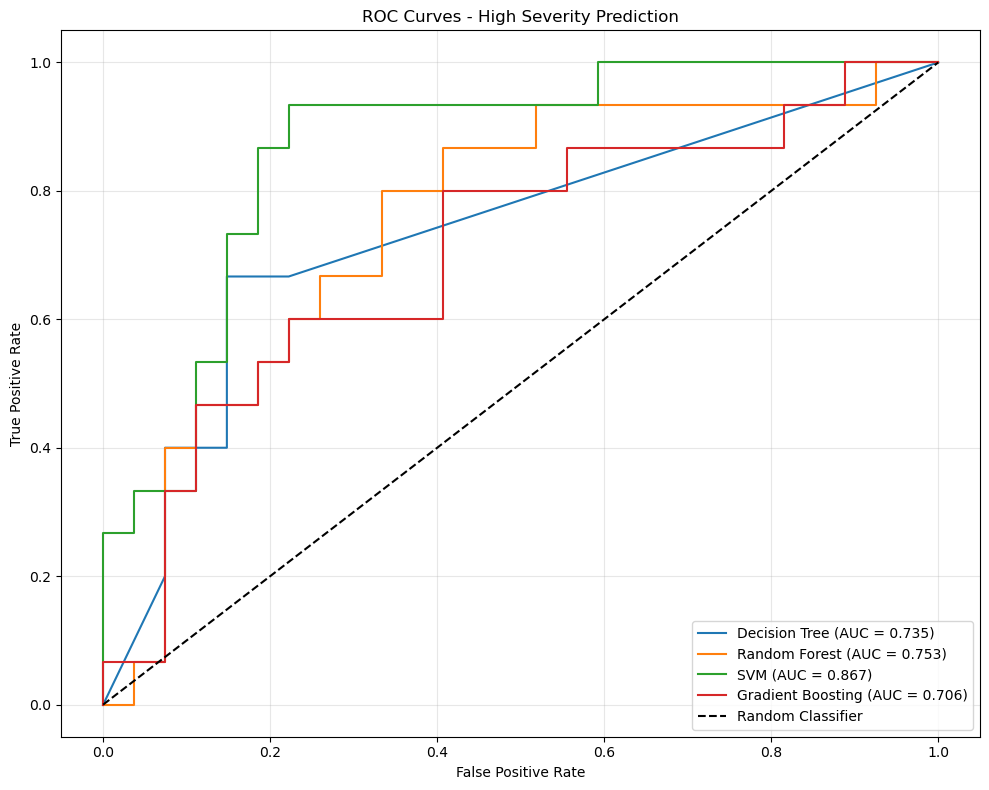

In [17]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

models_probas = [
    ('Decision Tree', dt_proba),
    ('Random Forest', rf_proba),
    ('SVM', svm_proba),
    ('Gradient Boosting', gb_proba)
]

for name, proba in models_probas:
    if proba is not None:
        fpr, tpr, _ = roc_curve(y_test, proba)
        auc = roc_auc_score(y_test, proba)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - High Severity Prediction')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(OUTPUTS_PATH + 'figures/roc_curves.png', dpi=150, bbox_inches='tight')
plt.show()

---
## Additional Classification Tasks

### Predicting Long-Duration Outages

In [18]:
# Prepare data for long duration prediction
X_dur, y_dur = prepare_classification_data(df, 'is_long_duration', all_features, categorical_features)

X_train_dur, X_test_dur, y_train_dur, y_test_dur = train_test_split(
    X_dur, y_dur, test_size=0.2, random_state=42, stratify=y_dur
)

print(f"Long Duration Prediction")
print(f"Class distribution: {y_dur.value_counts().to_dict()}")
print(f"Positive class rate: {y_dur.mean()*100:.1f}%")

# Train Random Forest (best performing model)
rf_dur = RandomForestClassifier(
    n_estimators=100, max_depth=10, min_samples_split=5,
    class_weight='balanced', random_state=42, n_jobs=-1
)

rf_dur_metrics, rf_dur_pred, rf_dur_proba, rf_dur_trained = evaluate_classifier(
    rf_dur, X_train_dur, X_test_dur, y_train_dur, y_test_dur, 'Random Forest (Duration)'
)

print(f"\nRandom Forest Performance for Long Duration Prediction:")
for metric, value in rf_dur_metrics.items():
    if metric != 'Model' and not pd.isna(value):
        print(f"  {metric}: {value:.4f}")

print(f"\nClassification Report:")
print(classification_report(y_test_dur, rf_dur_pred, target_names=['Short/Medium', 'Long Duration']))

Long Duration Prediction
Class distribution: {0: 131, 1: 79}
Positive class rate: 37.6%

Random Forest Performance for Long Duration Prediction:
  Accuracy: 0.6190
  Precision: 0.5000
  Recall: 0.3750
  F1 Score: 0.4286
  ROC-AUC: 0.5601
  CV F1 (mean): 0.5961
  CV F1 (std): 0.1591

Classification Report:
               precision    recall  f1-score   support

 Short/Medium       0.67      0.77      0.71        26
Long Duration       0.50      0.38      0.43        16

     accuracy                           0.62        42
    macro avg       0.58      0.57      0.57        42
 weighted avg       0.60      0.62      0.61        42



---
## Hyperparameter Tuning

Optimize Random Forest parameters using GridSearchCV.

In [19]:
# Hyperparameter tuning for Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

print("Running GridSearchCV for Random Forest...")
print("This may take a few minutes...\n")

rf_grid = GridSearchCV(
    RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1),
    param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

rf_grid.fit(X_train, y_train)

print(f"\nBest Parameters: {rf_grid.best_params_}")
print(f"Best CV F1 Score: {rf_grid.best_score_:.4f}")

# Evaluate best model on test set
y_pred_best = rf_grid.best_estimator_.predict(X_test)
y_proba_best = rf_grid.best_estimator_.predict_proba(X_test)[:, 1]

print(f"\nTest Set Performance (Tuned Random Forest):")
print(f"  Accuracy: {accuracy_score(y_test, y_pred_best):.4f}")
print(f"  F1 Score: {f1_score(y_test, y_pred_best):.4f}")
print(f"  ROC-AUC: {roc_auc_score(y_test, y_proba_best):.4f}")

Running GridSearchCV for Random Forest...
This may take a few minutes...

Fitting 5 folds for each of 108 candidates, totalling 540 fits

Best Parameters: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best CV F1 Score: 0.6559

Test Set Performance (Tuned Random Forest):
  Accuracy: 0.7619
  F1 Score: 0.6154
  ROC-AUC: 0.7778


In [21]:
# Save best model and results
import joblib

# Save the tuned Random Forest model
joblib.dump(rf_grid.best_estimator_, OUTPUTS_PATH + 'models/random_forest_severity.joblib')
print("Saved tuned Random Forest model to outputs/models/random_forest_severity.joblib")

# Save model comparison results
all_metrics.to_csv(OUTPUTS_PATH + 'classification_results.csv', index=False)
print("Saved classification results to outputs/classification_results.csv")

# Save feature importance
feature_importance.to_csv(OUTPUTS_PATH + 'feature_importance.csv', index=False)
print("Saved feature importance to outputs/feature_importance.csv")

print("\nClassification analysis complete!")

Saved tuned Random Forest model to outputs/models/random_forest_severity.joblib
Saved classification results to outputs/classification_results.csv
Saved feature importance to outputs/feature_importance.csv

Classification analysis complete!
